# A Hands-On Introduction to BART

[Martin Uecker](mailto:uecker@tugraz.at)$^{\dagger,*,+}$, [Nick Scholand](mailto:scholand@tugraz.at)$^{*,+}$, [Moritz Blumenthal](mailto:moritz.blumenthal@med.uni-goettingen.de)$^*$, [Xiaoqing Wang](mailto:xiaoqing.wang@med.uni-goettingen.de)$^{*,+}$

$^{\dagger}$Graz University of Technology, $^*$University Medical Center Göttingen, $^+$German Centre for Cardiovascular Research, Partner Site Göttingen

## Requirements




### Local Usage
- Install bart from its [github repository](https://github.com/mrirecon/bart)  (the newest version is needed for machine learning)
- Set the `TOOLBOX_PATH` to the BART directory and add it to the `PATH`

```bash
export TOOLBOX_PATH=/path/to/bart  
export PATH=$TOOLBOX_PATH:$PATH
```

Although the simplest way to call the BART CLI tools is from a terminal, there are also wrapper functions that allow the tools to be used from Matlab and Python. These are located under the `$TOOLBOX_PATH/matlab` and `$TOOLBOX_PATH/python` directories.

### Online Usage
MyBinder and Google Colaboratory can be used to access a Jupyter instance with BART with a browser. In the following we install and configure BART for both.

#### Check for GPU

**Google Colaboratory** provides access to a GPU. To enable it:

- Go to Edit → Notebook Settings
- choose GPU from Hardware Accelerator drop-down menu

**MyBinder** does not provide GPU access.

The following code will automatically detect which service you are using.

In [10]:
# Check if notebook runs on colab
import sys, os

os.environ['COLAB'] = 'true' if ('google.colab' in sys.modules) else 'false'

# FIXME: Colab without GPU not supported yet
os.environ['CUDA'] = '1' if ('google.colab' in sys.modules) else '0'

In [11]:
%%bash

# Prepare GPUs if on Google Colab
if $COLAB; then

    # Use CUDA 10.1 when on Tesla K80

    # Determine GPU Type
    GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

    echo "GPU Type:"
    echo $GPU_NAME

    if [ "Tesla K80" = "$GPU_NAME" ]; then

        echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

        cd /usr/local
        rm cuda
        ln -s cuda-10.1 cuda
    fi

    echo "GPU Information:"
    nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
    nvcc --version
fi

GPU Type:
Tesla T4
GPU Information:
name, driver_version, memory.total [MiB]
Tesla T4, 525.85.12, 15360 MiB
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


#### BART Installation

Here we install BARTs dependencies, clone its repository from github, and compile it.

In [3]:
%%bash

# MyBinder has BART already installed via the container
if $COLAB; then

  # Install BARTs dependencies
  apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

  # Clone Bart
  [ -d /content/bart ] && rm -r /content/bart
  git clone https://github.com/mrirecon/bart/ bart &> /dev/null
fi

In [4]:
%%bash

if $COLAB; then

  cd bart

  # Configuration
  COMPILE_SPECS=" PARALLEL=1
                  CUDA=$CUDA
                  CUDA_BASE=/usr/local/cuda
                  CUDA_LIB=lib64
                  OPENBLAS=1
                  BLAS_THREADSAFE=1"

  printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

  # Compile BART
  make &> /dev/null && echo ok
fi

ok


#### Setup Environment for BART

After downloading and compiling BART, the next step simplifies the handling of BARTs command line interface inside an ipyhton jupyter notebook. We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [5]:
os.environ['TOOLBOX_PATH'] = "./bart"
os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python/")

Check BART setup:

In [6]:
%%bash
echo "# BART version: "
bart version

# BART version: 
v0.8.00-305-gf405f63


### Setup Visualization Helper

For this tutorial we will visualize some images. Therefore, we need a helper function and some python libraries.


In [22]:
# More python libraries
import cfl
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image

def plot_map(dataname, colorbar, vmin, vmax, cbar_label):

    # Import data        
    data = np.abs(cfl.readcfl(dataname).squeeze())

    # Import colorbar type
    colorbartype =  colorbar

    # Set zero to a black color for a masking effect
    my_cmap = cm.get_cmap(colorbartype, 256)
    my_cmap.set_bad('black')

    data = np.ma.masked_equal(data, 0)

    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(111)
    im = ax1.imshow(data, interpolation='nearest', cmap=my_cmap, vmin=vmin, vmax=vmax)

    # Style settings
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(cbar_label)
    cbar.ax.tick_params()

    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.xaxis.set_ticks_position('none')
    ax1.yaxis.set_ticks_position('none')
    ax1.set_axis_off()

    plt.show()

### Download Supporting Materials
For this tutorial, we also need several supporting materials (figures, plotting scripts and compressed data for ML part). They are stored in the GitHub repository and need to be downloaded.

In [8]:
%%bash

# Download the required supporting material if it is not already there
[ ! -f data.zip ] && wget -q https://github.com/mrirecon/bart-workshop/raw/master/mri_together_2021/data.zip
unzip -n data.zip

# Download Raw Data for IR FLASH parts
name=IR-FLASH

if [[ ! -f ${name} ]]; then
  echo Downloading ${name}
  wget -q https://zenodo.org/record/4060287/files/${name}.cfl
  wget -q https://zenodo.org/record/4060287/files/${name}.hdr

  mv ${name}.cfl data/${name}.cfl
  mv ${name}.hdr data/${name}.hdr
fi

head -n2 data/${name}.hdr

Archive:  data.zip
   creating: data/
  inflating: data/kspace_fs.cfl      
  inflating: data/modl.cfl           
  inflating: data/modl.hdr           
  inflating: data/pattern_po_4.cfl   
  inflating: data/pattern_po_4.hdr   
  inflating: data/varnet.hdr         
  inflating: data/varnet.cfl         
  inflating: data/IR_FLASH.png       
  inflating: data/operator_chain.png  
  inflating: data/kspace_fs.hdr      
# Dimensions
512 1 1 16 1 1 1 1 1 1 1020 1 1 1 1 1 


## BART Fundamentals
BART provides a number of tools for MRI image reconstruction and multi-dimensional array manipulation.

In [13]:
# get a list of BART commands by running bart with no arguments:
! bart

BART. Available commands are:
avg         bench       bin         bitmask     cabs        caldir      
calmat      carg        casorati    cc          ccapply     cdf97       
circshift   conj        conv        conway      copy        cpyphs      
creal       crop        delta       ecalib      ecaltwo     epg         
estdelay    estdims     estshift    estvar      extract     fakeksp     
fft         fftmod      fftrot      fftshift    filter      flatten     
flip        fmac        fovshift    homodyne    ictv        index       
invert      itsense     join        looklocker  lrmatrix    mandelbrot  
measure     mip         mnist       moba        mobafit     morphop     
multicfl    nlinv       nnet        noise       normalize   nrmse       
nufft       onehotenc   ones        pattern     phantom     pics        
pocsense    poisson     pol2mask    poly        reconet     repmat      
reshape     resize      rmfreq      rof         roistat     rss         
rtnlinv     sake     

### BART Command Structure

The command structure follows

> **`bart`** + **`command`** + **`options`** + **`input / output`**

Each BART command consists of a number of optional arguments, followed by input and output files.To get some information about a command, use the -h flag. Optional arguments are indicated by brackets, and files are indicated by carrot symbols.


In [14]:
! bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <file>] [-G] [-T] [--NIST] [--SONAR] [-N d] [-B] [-x d] [-g d] [-3] [-b] [-r d] [--rotation-angle f] [--rotation-steps d] <output> 

Image and k-space domain phantoms.

-s nc                     nc sensitivities
-S nc                     Output nc sensitivities
-k                        k-space
-t file                   trajectory
-G                        geometric object phantom
-T                        tubes phantom
--NIST                    NIST phantom (T2 sphere)
--SONAR                   Diagnostic Sonar phantom
-N num                    Random tubes phantom and number
-B                        BART logo
-x n                      dimensions in y and z
-g n=1,2,3                select geometry for object phantom
-3                        3D
-b                        basis functions for geometry
-r seed                   random seed initialization
--rotation-angle [deg]    Angle of Rotation
--rotation-steps          Number of rotation steps
-

The `phantom` tool includes the option `-k` to create it in k-space, and `-x` to specify the size.

Shepp-Logan k-space phantom


<ipython-input-22-dc067f803333>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = cm.get_cmap(colorbartype, 256)


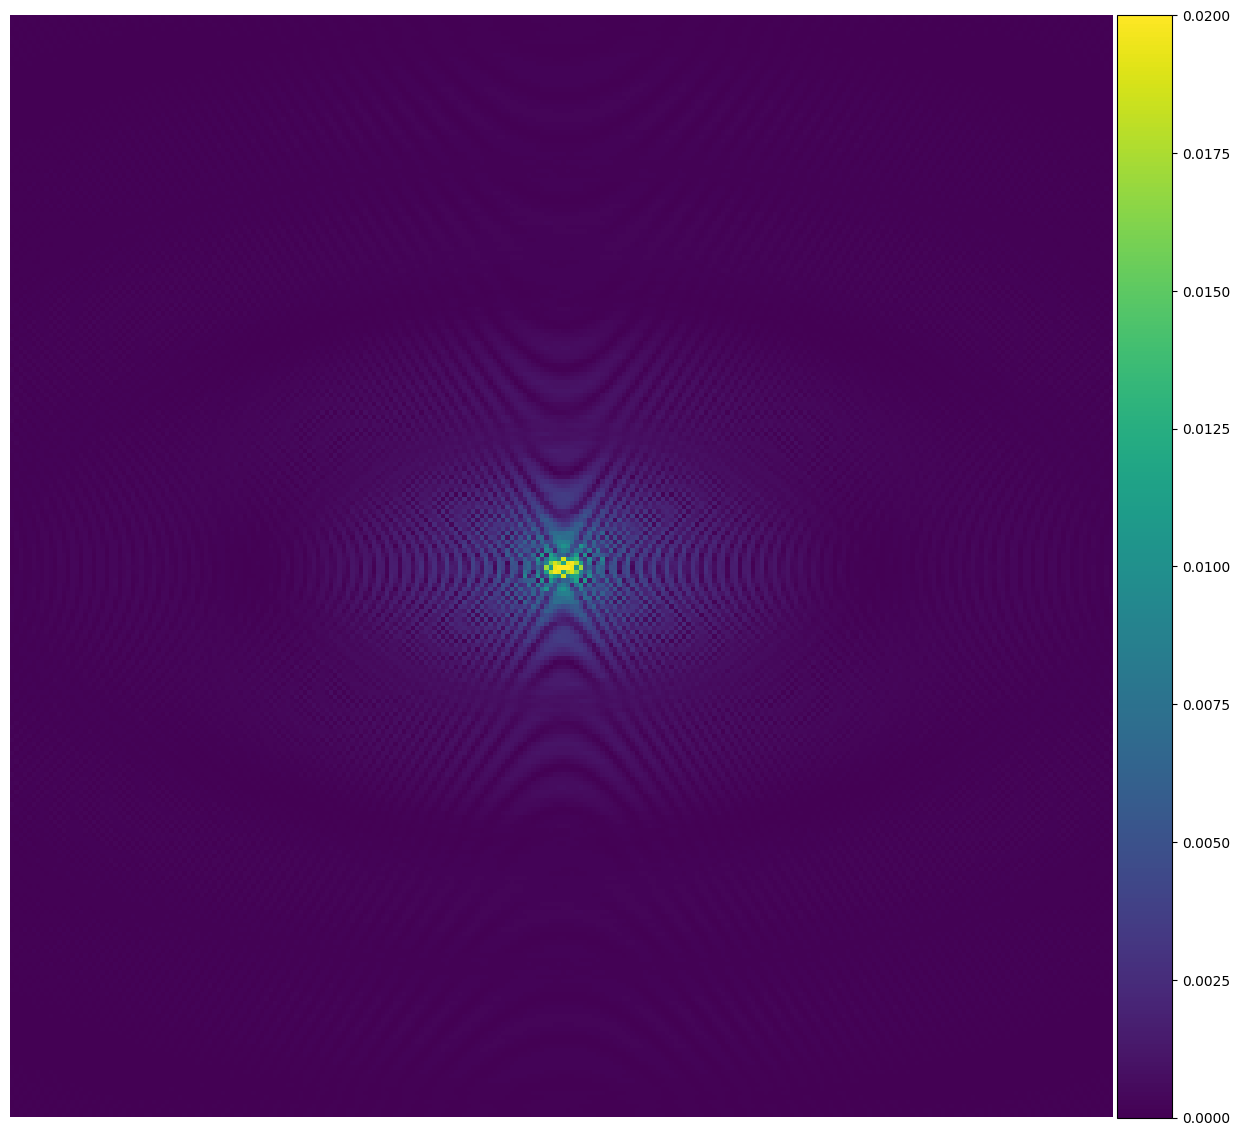

In [23]:
# Create Cartesian k-space phantom (256 samples)
! bart phantom -x 256 -k shepp_logan

! echo "Shepp-Logan k-space phantom"
plot_map("shepp_logan", "viridis", 0, 0.02, '')

### Data File Format
All data files are multi-dimensional arrays. By running the `phantom` command, we made new files on disk, with the names  
`shepp_logan.cfl` and `shepp_logan.hdr`

The header (`hdr`) is a text file that contains the data dimensions and additional information. The data file (`cfl`) contains the complex single-precision raw data in column-major order and with interleaved real and imaginary parts.  

The header file is a raw text file and can be opened with any text editor. The complex-float file is a binary file. Matlab and Python readers/writers are available under the `matlab` and `python` directories, respectively.

### View data dimensions
Because the header file is a text file, we can directly print it:

In [24]:
! cat shepp_logan.hdr

# Dimensions
256 256 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
# Command
phantom -x 256 -k shepp_logan 
# Files
 >shepp_logan
# Creator
BART v0.8.00-305-gf405f63


Although not discussed here, BART can write to other file formats that might not have a text header. Thus, it is better to use the show command:

In [25]:
! bart show -m shepp_logan

Type: complex float
Dimensions: 16
AoD:	256	256	1	1	1	1	1	1	1	1	1	1	1	1	1	1


Our dataset is 16-dimensional, but only the first two dimensions are non-singleton.

By convention, the dimensions are `[X, Y, Z, C, M, T, F, ...]`,
where `(X, Y, Z)` are the spatial matrix dimensions,  
`C` and `M` are the coil dimensions and ESPIRiT maps dimensions, respectively,  
`T` and `F` are used for echo times and coefficient dimensions,   
followed by other higher order dimensions such as flow encoding, etc.

### Using Bitmasks to select dimensions
Let's reconstruct our k-space phantom using a inverse Fast Fourier Transform (iFFT).

IFFT of Shepp-Logan phantom


<ipython-input-22-dc067f803333>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = cm.get_cmap(colorbartype, 256)


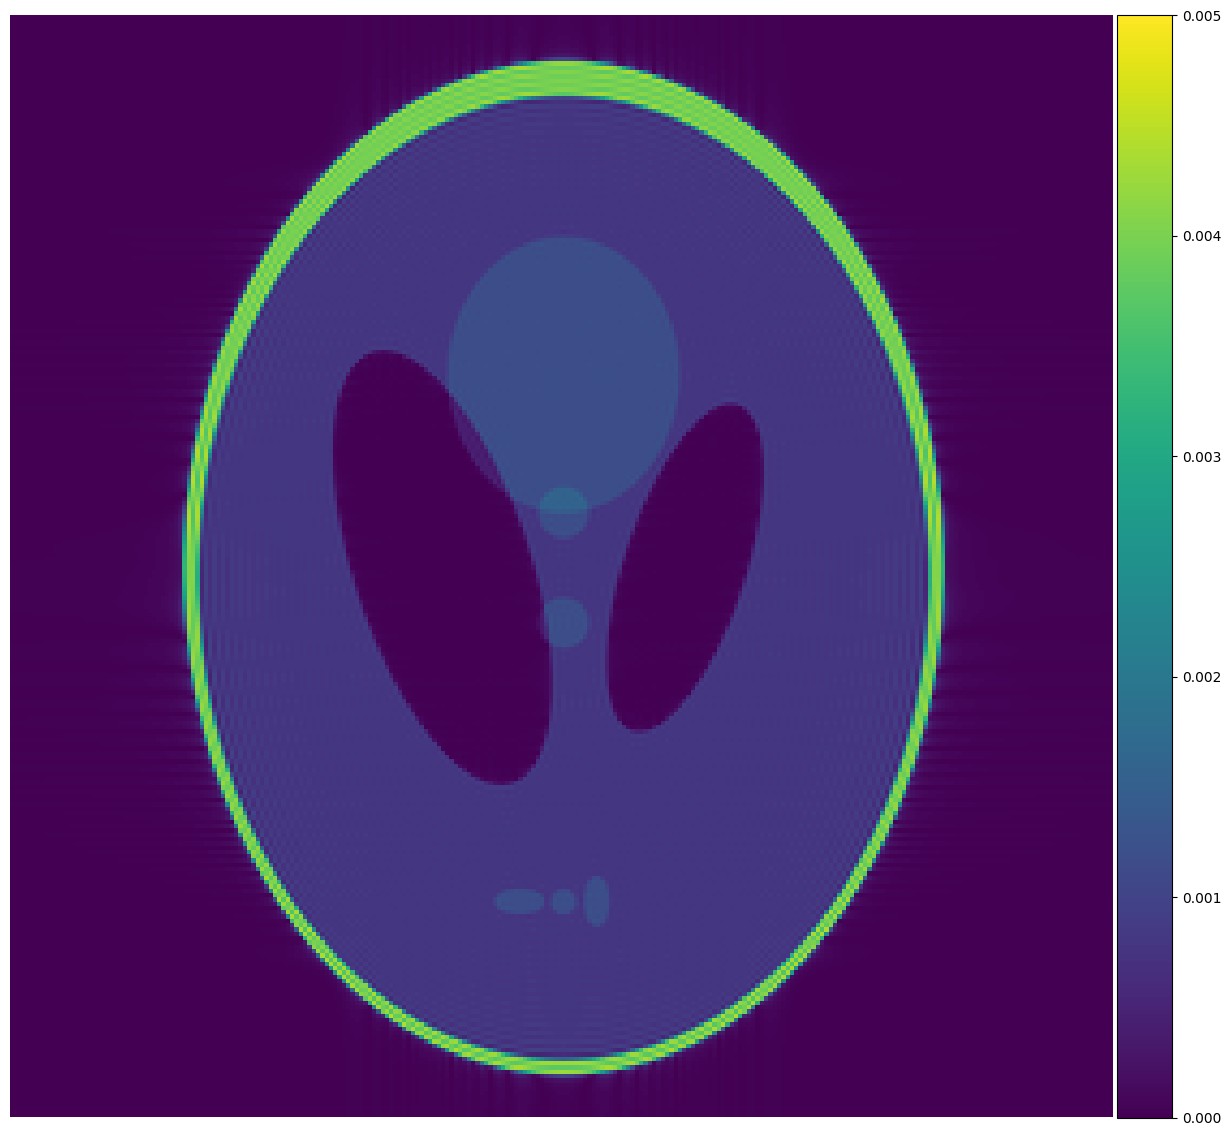

In [26]:
# Perform FFT reconstruction
! bart fft -u -i 3 shepp_logan shepp_logan_rec

! echo "IFFT of Shepp-Logan phantom"
plot_map("shepp_logan_rec", "viridis", 0, 0.005, '')

In [27]:
# Show help for fft command
! bart fft -h

Usage: fft [-u] [-i] [-n] bitmask <input> <output> 

Performs a fast Fourier transform (FFT) along selected dimensions.

-u    unitary
-i    inverse
-n    un-centered
-h    help


Thus, we performed an inverse (`-i`) unitary (`-u`) Fast Fourier Transform on the image dimensions **`(0, 1)`** specified by the bitmask **`3`**.


BART loops over dimensions selected by *bitmasks*. This is a powerful approach for perfoming multi-dimensional operations, as most tools will work on arbitrarily chosen dimensions.  

In our case, we wanted to perform an iFFT along dimensions 0 and 1, and the corresponding bitmask is calculated as:  
<center>
$ \text{bitmask}=2^{~0} + 2^{~1} = 3$
</center> <br>
BART also provides a command-line tool to calculate the bitmasks for specific dimensions.

In [28]:
# Calculate bitmask for active dimensions 0 and 1
! bart bitmask 0 1

3


## BART Examples


### Subspace T1 Mapping

A complete tutorial for subspace T1 mapping with BART can be found in the [3rd BART Webinar Materials](https://github.com/mrirecon/bart-webinars/tree/master/webinar3).

#### Theory

**Single-Shot Inversion-Prepared T1 Mapping**

<img src="https://github.com/mrirecon/bart-workshop/blob/master/ismrm2021/model_based/IR_FLASH.png?raw=1" style="width: 550px;">







#### Dictionary Generation, SVD and Temporal Basis

Calculate dictionary.

In [29]:
%%bash

TR=0.0041

# Dictionary characteristics
## R1s
#NUM_R1S=1000
# only use 100 for demo
NUM_R1S=100
MIN_R1S=5e-3
MAX_R1S=5

## Mss
NUM_MSS=100
MIN_MSS=1e-2
MAX_MSS=1

# Read file dimensions from downloaded dataset
REP=`bart show -d 10 data/IR-FLASH`

# Simulate dictionary based on the `signal` tool
bart signal -F -I -n$REP -r$TR \
            -1 $MIN_R1S:$MAX_R1S:$NUM_R1S \
            -3 $MIN_MSS:$MAX_MSS:$NUM_MSS  dicc

# reshape the dicc 6th and 7th dimension to have all the elements 
# concentrated in the 6th dimension
bart reshape $(bart bitmask 6 7) $((NUM_R1S * NUM_MSS)) 1 dicc dicc_reshape

# squeeze the reshaped dictionary to remove singleton dimensions
bart squeeze dicc_reshape dicc_squeeze

Perform a SVD to create our temporal basis with a given number of coefficients.

In [30]:
%%bash

NUM_COE=4

# Perform an SVD of the dictionary and output a
# decomposition of the resulting matrix
bart svd -e dicc_squeeze U S V

# Extract desired number of orthonormal columns from U
bart extract 1 0 $NUM_COE U basis0

# Transpose the basis to have time in the 5th dimension 
# and coefficients in the 6th dimension
bart transpose 1 6 basis0 basis1
bart transpose 0 5 basis1 basis

# Print the transposed basis dimensions
echo "Temporal Basis"
head -n2 basis.hdr

Temporal Basis
# Dimensions
1 1 1 1 1 1020 4 1 1 1 1 1 1 1 1 1 


#### Coil Compression
To reduce the size of our dataset and therefore also decrease the computational complexity, we perform a coil compression with the `cc` command. By passing `-A` we choose to use all possible data and to reduce the dataset to 8 virtual coils with `-p`.


In [31]:
%%bash

# Transpose the 0th and 1st dimension of the downloaded data
# to ensure compatibility with BARTs non-Cartesian tools
bart transpose 0 1 data/IR-FLASH ksp

# Perform coil compression
bart cc -A -p 8 ksp ksp_cc

Done.


#### Trajectory Generation

In the next step we generate a trajectory with the `traj` tool. To match the acquisition of the downloaded data, we need to specify radial `-r`, centered `-c`, double-angle `-D`, 7th tiny golden-angle `-G -s7` sampling. The number of turns are passed using `-t`, the spokes using `-y` and the samples using `-x`.

In [32]:
%%bash

# Tiny golden angle
NUM_TGA=7

# Read file dimensions from downloaded dataset
READ=`bart show -d 0 data/IR-FLASH`
SPOKES=`bart show -d 2 data/IR-FLASH`
REP=`bart show -d 10 data/IR-FLASH`

# Create the trajectory using the `traj` tool
bart traj -r -c -D -G -x$READ -y$SPOKES -s$NUM_TGA -t$REP traj

# Print out its dimensions
echo "Trajectory"
head -n2 traj.hdr

Trajectory
# Dimensions
3 512 1 1 1 1 1 1 1 1 1020 1 1 1 1 1 


#### Gradient Delay Correction
Because the signal is following an IR FLASH curve, the gradient-delay correction should be applied to the data from the last repetitions which are in a steady-state. Therefore, we extract repetitions from the end of the trajectory and the dataset using the `extract` command. Have in mind that the time dimension is the 10th here!

In [33]:
%%bash

# Tiny golden angle
NUM_TGA=7

# Define the number of TRs the gradient delay correction should be 
# performed on (Steady-State)
FRAMES_FOR_GDC=100

# Read file dimensions from downloaded dataset
READ=`bart show -d 0 data/IR-FLASH`
SPOKES=`bart show -d 2 data/IR-FLASH`
REP=`bart show -d 10 data/IR-FLASH`

# Extract the DATA_GDC last time frames from the trajectory and the dataset
bart extract 10 $((REP - FRAMES_FOR_GDC)) $REP traj traj_extract
bart extract 10 $((REP - FRAMES_FOR_GDC)) $REP ksp_cc ksp_extract

# Transpose the 2nd and 10th dimension for later use with the `estdelay` tool
bart transpose 10 2 traj_extract traj_extract1
bart transpose 10 2 ksp_extract ksp_extract1

# Estimate and store the gradient delays usign RING
GDELAY=$(bart estdelay -R traj_extract1 ksp_extract1)

echo "Gradient Delays: "$GDELAY

# Calculate the trajectory with known gradient delays
bart traj -r -c -D -G -x$READ -y$SPOKES -s$NUM_TGA -q$GDELAY -t$REP trajn2

# 2x oversampling
bart scale 0.5 trajn2 trajn

Gradient Delays: -0.120593:0.161684:0.009525


WARN: DC is shifted by: 0.000000 [sample], 1 sample = 1.000000 [1/FOV]


#### Coil Sensitivity Estimation

The coil profile estimation is similar to the gradient delay estimation performed on some of the last timesteps of the IR FLASH dataset.`extract` command.

In [34]:
%%bash

# number of TRs at end of the dataset to be used
FRAMES_FOR_CSE=300

# Read file dimensions from downloaded dataset
READ=`bart show -d 0 data/IR-FLASH`
SPOKES=`bart show -d 2 data/IR-FLASH`
REP=`bart show -d 10 data/IR-FLASH`

# Extract last time frames (10th dim) from trajectory and k-space data
bart extract 10 $((REP - FRAMES_FOR_CSE)) $REP trajn traj_ss
bart extract 10 $((REP - FRAMES_FOR_CSE)) $REP ksp_cc ksp_cc_ss

bart transpose 2 10 traj_ss traj_ss2
bart transpose 2 10 ksp_cc_ss ksp_cc_ss2

# Apply an inverse non-uniform FFT
bart nufft -i -d$(($READ / 2)):$(($READ / 2)):1 traj_ss2 ksp_cc_ss2 img


# transform reconstruction in image space back to k-space
bart fft -u $(bart bitmask 0 1 2) img ksp_grid

# Estimate coil sensitivities
bart ecalib -S -t0.01 -m1 ksp_grid sens_invivo

cat sens_invivo.hdr

Done.
Done.
# Dimensions
256 256 1 8 1 1 1 1 1 1 1 1 1 1 1 1 
# Command
ecalib -S -t0.01 -m1 ksp_grid sens_invivo 
# Files
 >sens_invivo <ksp_grid
# Creator
BART v0.8.00-305-gf405f63


In [35]:
%%bash
# Reshape and flip coefficient maps for improved visualization

# Read file dimensions
READ=`bart show -d 0 sens_invivo`
COILS=`bart show -d 3 sens_invivo`

## Merge all coefficients in the column dimension (1st/phase1)
bart reshape $(bart bitmask 1 3) $((READ * COILS)) 1 sens_invivo sens_invivo_lin

## Flip the map in row dimension
bart flip $(bart bitmask 0) sens_invivo_lin sens_invivo_flip

In-Vivo Sensitivity Maps


<ipython-input-22-dc067f803333>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = cm.get_cmap(colorbartype, 256)


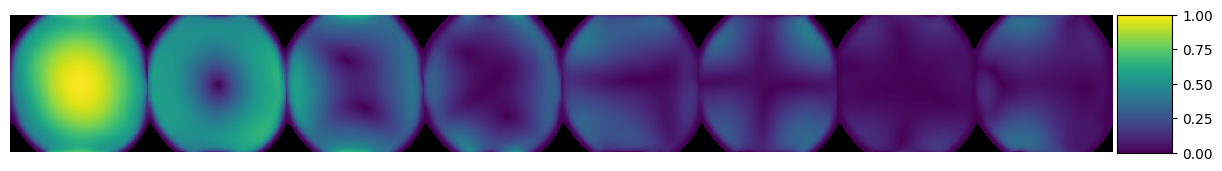

In [36]:
! echo "In-Vivo Sensitivity Maps"
plot_map("sens_invivo_flip", "viridis", 0, 1, '')

#### Subspace-Constrained Reconstruction


In [37]:
%%bash

# Transpose dimensions for working with PICS tool
bart transpose 5 10 trajn traj_final
bart transpose 5 10 ksp_cc ksp_final

READ=`bart show -d 0 sens_invivo`

DEBUG=4
ITER=100
REG=0.0015

if $COLAB; then
    GPU=-g;
else
    GPU=''
fi

bart pics   $GPU -e -d $DEBUG -i$ITER \
            -RW:$(bart bitmask 0 1):$(bart bitmask 6):$REG \
            -t traj_final -B basis \
            ksp_final sens_invivo coeff_maps

echo "Reconstructed Coefficients"
head -n2 coeff_maps.hdr

Basis: [256 256   1   8   1 1020   4   1   1   1   1   1   1   1   1   1 ]
Max:   [256 256   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
GPU reconstruction
[  1 512   1   8   1 1020   4   1   1   1   1   1   1   1   1   1 ]
[256 256   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 512   1   8   1 1020   4   1   1   1   1   1   1   1   1   1 ]
cim : [256 256   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512   1   1   1 1020   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 512   1   1   1 1020   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 1020   4   1   1   1   1   1   1   1   1   1 ]
[  1   1   1   1   1 1020   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
nufft kernel dims: [  1 512   1   1   1   4   4   1   1   1   1   1   1   1   1   1   1 1020 ]
nufft psf dims:    [512 512   1   1   1   4   4   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 512   1   1   1   1   1   

#### Visualization of Reconstructed Maps

In [38]:
%%bash
# Reshape and flip coefficient maps for improved visualization

READ=`bart show -d 0 coeff_maps`
NCOE=`bart show -d 6 coeff_maps`

## Merge all coefficients in the column dimension (1st/phase1)
bart reshape $(bart bitmask 1 6) $((READ * NCOE)) 1 coeff_maps subspace_maps

## Flip the map in row dimension to have correct orientation
bart flip $(bart bitmask 0) subspace_maps subspace_maps1

Subspace Coefficient Maps


<ipython-input-22-dc067f803333>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = cm.get_cmap(colorbartype, 256)


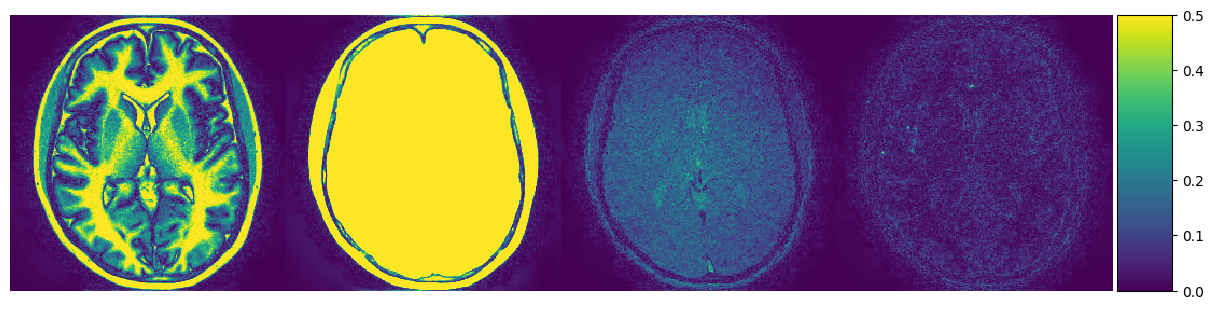

In [39]:
! echo "Subspace Coefficient Maps"
plot_map("subspace_maps1", "viridis", 0, 0.5, '')

### Model-Based T1 Mapping

A complete tutorial for model-based reconstructions in BART can be found in the [Workshop Material of the ISMRM 2021](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021).

**Operator chain of parallel imaging and signal model (nonlinear)**

<img src="https://github.com/mrirecon/bart-workshop/blob/master/ismrm2021/model_based/operator_chain.png?raw=1" style="width: 400px;">

$$F: x \mapsto y = {\mathcal{P} \mathcal{F} C} \cdot {M(x_{p})}$$
- $\mathcal{P}$ - sampling pattern
- $\mathcal{F}$ - Fourier transform
- $C$ - coil sensitivity maps
- $M(\cdot)$ - MR physics model
- $x_{p}$ - MR parameters
- $y$ - acquired kspace data

#### Optimization

We use the iteratively regularized Gauss-Newton method (IRGNM) in BART to  directly estimate the MR parameter maps from undersampled k-space datasets. No pixel-wise fitting or intermediate reconstruction of contrast-weighted images is required!

For further information have a look into:

> Wang X, Roeloffs V, Klosowski J, Tan Z, Voit D, Uecker M, Frahm J.,  
[Model-based T1 Mapping with Sparsity Constraints Using Single-Shot Inversion-Recovery Radial FLASH](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.26726).  
Magn Reson Med 2018;79:730-740.

In [40]:
%%bash
bart moba -h

Usage: moba [-r ...] [-L] [-P] [-F] [-G] [--bloch] [-m d] [-l d] [-i d] [-R,--reduction f] [-T f] [-j f] [-u f] [-C d] [-s f] [-B f] [-b f:f] [-d d] [-f f] [-p <file>] [-J] [-M] [-g] [--positive-maps d] [--not-wav-maps d] [--l2-on-parameters d] [--pusteps d] [--ratio f] [--l1val f] [--multi-gpu d] [-I <file>] [-t <file>] [-o f] [--img_dims d:d:d] [-k] [--kfilter-1] [--kfilter-2] [-e f] [--fat_spec_0] [--scale_data f] [--seq ...] [--sim ...] [--other ...] <kspace> <TI/TE> <output> [<sensitivities>] 

Model-based nonlinear inverse reconstruction

-r <T>:A:B:C               generalized regularization options (-rh for help)
-L                         T1 mapping using model-based look-locker
-P                         T1 mapping using reparameterized (M0, R1, alpha) model-based look-locker (TR required!)
-F                         T2 mapping using model-based Fast Spin Echo
-G                         T2* mapping using model-based multiple gradient echo
--bloch                    Bloch model

#### Coil Compression

Compress data to 3 coils, for good quality use 8 or more.


In [41]:
%%bash

NUM_VCOILS=3

## Coil compression
bart transpose 0 1 data/IR-FLASH ksp

# coil compression
bart cc -A -p $NUM_VCOILS ksp ksp_cc

Done.


#### Trajectory Preparation with Gradient Delay Correction

In [60]:
%%bash

READ=`bart show -d 0 data/IR-FLASH`
SPOKES=`bart show -d 1 data/IR-FLASH`
REP=`bart show -d 10 data/IR-FLASH`

## Prepare radial trajectory (golden-angle)
bart traj -r -c -D -G -x$READ -y$SPOKES -s7 -t$REP traj2

# Gradient Delay Correction
# Extract the steady-state data (data with less contrast change)
bart extract 10 920 1020 traj traj_extract
bart extract 10 920 1020 ksp_cc ksp_extract

# Transpose the 2nd and 10th dimension for the `estdelay` tool
bart transpose 10 2 traj_extract traj_extract1
bart transpose 10 2 ksp_extract ksp_extract1

# Gradient delay estimation usign RING
GDELAY=$(bart estdelay -R traj_extract1 ksp_extract1)

echo "Gradient Delays: "$GDELAY

# Calculate the "correct" trajectory with known gradient delays
bart traj -r -c -D -G -x$READ -y$SPOKES -s7 -t$REP -O -q $GDELAY trajn2

# 2x oversampling
bart scale -- 0.5 trajn2 trajn

Gradient Delays: -0.120477:0.166771:0.008643


WARN: DC is shifted by: 0.000000 [sample], 1 sample = 1.000000 [1/FOV]


#### Preparation of Inversion Times

In [61]:
%%bash

## Prepare time vector
TR=4100 #TR in [us]
BIN_SPOKES=20 # Bin data to save computation time 

# Read file dimensions from downloaded dataset
REP=`bart show -d 10 data/IR-FLASH`

NTIME=$((REP / BIN_SPOKES)) # Integer division!

# Create vector from 0 to NTIME
bart index 5 $NTIME tmp1
bart scale $(($BIN_SPOKES * $TR)) tmp1 tmp2
bart ones 6 1 1 1 1 1 $NTIME tmp1 
bart saxpy $((($BIN_SPOKES / 2) * $TR)) tmp1 tmp2 tmp3
bart scale 0.000001 tmp3 TI

# Reshape trajectory and data for model-based reconstruction
bart reshape $(bart bitmask 2 5 10) $BIN_SPOKES $NTIME 1 trajn traj_moba
bart reshape $(bart bitmask 2 5 10) $BIN_SPOKES $NTIME 1 ksp_cc ksp_cc_moba

# Resize data and trajectory for faster computation
bart resize -c 1 384 traj_moba traj_moba1
bart resize -c 1 384 ksp_cc_moba ksp_cc_moba1

echo "Trajectory:"
head -n2 traj_moba1.hdr

echo "Data:"
head -n2 ksp_cc_moba1.hdr

echo "TI:"
head -n2 TI.hdr''

Trajectory:
# Dimensions
3 384 20 1 1 51 1 1 1 1 1 1 1 1 1 1 
Data:
# Dimensions
1 384 20 3 1 51 1 1 1 1 1 1 1 1 1 1 
TI:
# Dimensions
1 1 1 1 1 51 1 1 1 1 1 1 1 1 1 1 


#### Nonlinear Model-based Reconstruction

The full nonlinear reconstruction can be applied to data by using only the `moba` command in the BART CLI. No coil sensitivity information is necessary, because they are jointly estimated. We apply a non-linear inversion-recovery Look-Locker model `-L` to our single-shot data. We also exploit compressed sensing by adding a wavelet $l_1$ regularization with the `-l1` flag.

In [91]:
%%bash

if $COLAB; then
    GPU=-g;
else
    GPU=''
fi

bart moba -L $GPU -d4 -i8 -l1 -C100 -j0.09 -B0.0 --other pinit=1:1:2:1 --scale_data=5000. --scale_psf=1000. --normalize_scaling -t traj_moba1 ksp_cc_moba1 TI reco_moba 

#-L                         --- to select look-locker model
#-g                         --- to use GPU
#-d                         --- debug level
#-l1                        --- to use l1-Wavelet regularization
#-i                         --- number of Newton-steps
#-C                         --- maximum number of inner iterations (FISTA)
#-j                         --- minimum regularization parameter
#-B                         --- lower bound for relaxivity (R1s > 0)
#--other pinit=%f:%f:%f:%f  --- Initialization of parameter maps: Mss, M0, R1s
#--scale_data=%f            --- Scaling of data
#--scale_psf=%f             --- Scaling of PSF
#--normalize_scaling        --- Normalize scaling by (data / psf)

# NOTE: There is no need of input of coil sensitivity maps, because we jointly estimate coils using model-based reconstruction

Est. image size: 192 194 1
nufft kernel dims: [  1 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
nufft psf dims:    [384 388   1   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
nufft traj dims:   [  3 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
Allocating 391680 (vs. 7990272) + 7598592
ksp : [  1 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [384 388   1   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 384  20   3   1  51   1   1   1   1   1   1   1   1   1   1 ]
cim : [384 388   1   3   1  51   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384  20   1   1  51   1   1   1   1   1   1   1   1   1   1 ]
Scaling: 13032.802734
Scaling_psf: 1.440485
T1 Model created:
 Model NLOP
inputs: 1
[384 388   1   1   1   1   3   1   1   1   1   1   1   1   1   1 ]
outputs: 1
[384 388   1   1   1  51   1   1   1   1   1   1 

#### Visualize Results

To visualize the output of the reconstruction we resize it and thus remove the applied oversampling. Additionally, we slice the individual maps out of its original file and place them next to each other for the final visualization.

In [92]:
%%bash

READ=`bart show -d 0 reco_moba`

# Remove oversampling for all maps
bart resize -c 0 $((READ / 2)) 1 $((READ / 2)) reco_moba reco_maps

# Merge all coefficients in the column dimension for visualization
bart reshape $(bart bitmask 1 6) $((3 * READ / 2)) 1 reco_maps reco_maps_lin

# Flip the maps in row dimension
bart flip $(bart bitmask 0) reco_maps_lin reco_maps_flip

Reconstructed Coefficient Maps: Mss, M0, R1s


<ipython-input-22-dc067f803333>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = cm.get_cmap(colorbartype, 256)


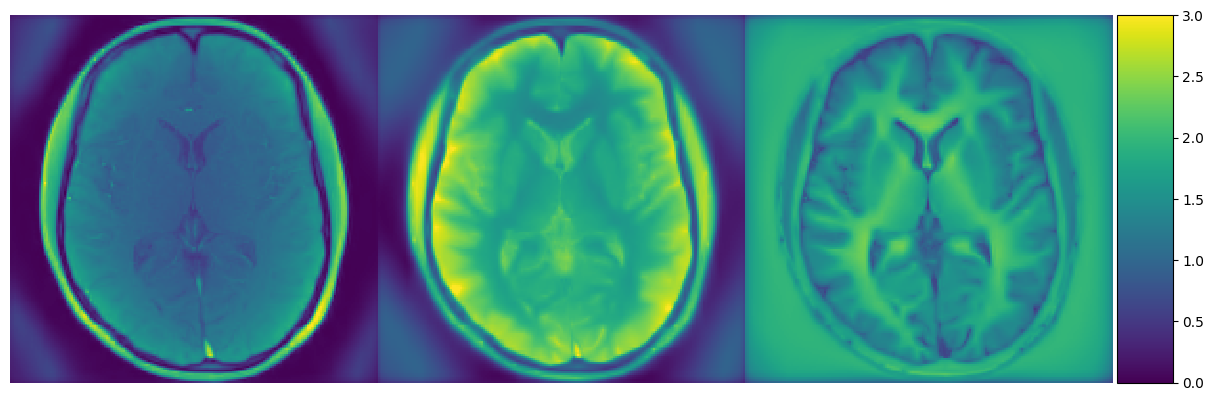

In [93]:
! echo "Reconstructed Coefficient Maps: Mss, M0, R1s"
plot_map("reco_maps_flip", "viridis", 0, 3, '')

The output of the nonlinear Look-Locker model-based reconstruction are the parameter maps Mss, M0 and R1*.   To estimate the desired T1 map we pass the reconstruction to the `looklocker` command and visualize the T1 map.

In [96]:
%%bash

INVERSION_DELAY=0.0153
THRESHOLD=0.2

# estimating T1 from the parameters  Mss, M0, R1s
bart looklocker -t $THRESHOLD -D $INVERSION_DELAY reco_maps tmp

# Flip the map in row dimension
bart flip $(bart bitmask 0) tmp moba_T1map

<ipython-input-22-dc067f803333>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = cm.get_cmap(colorbartype, 256)


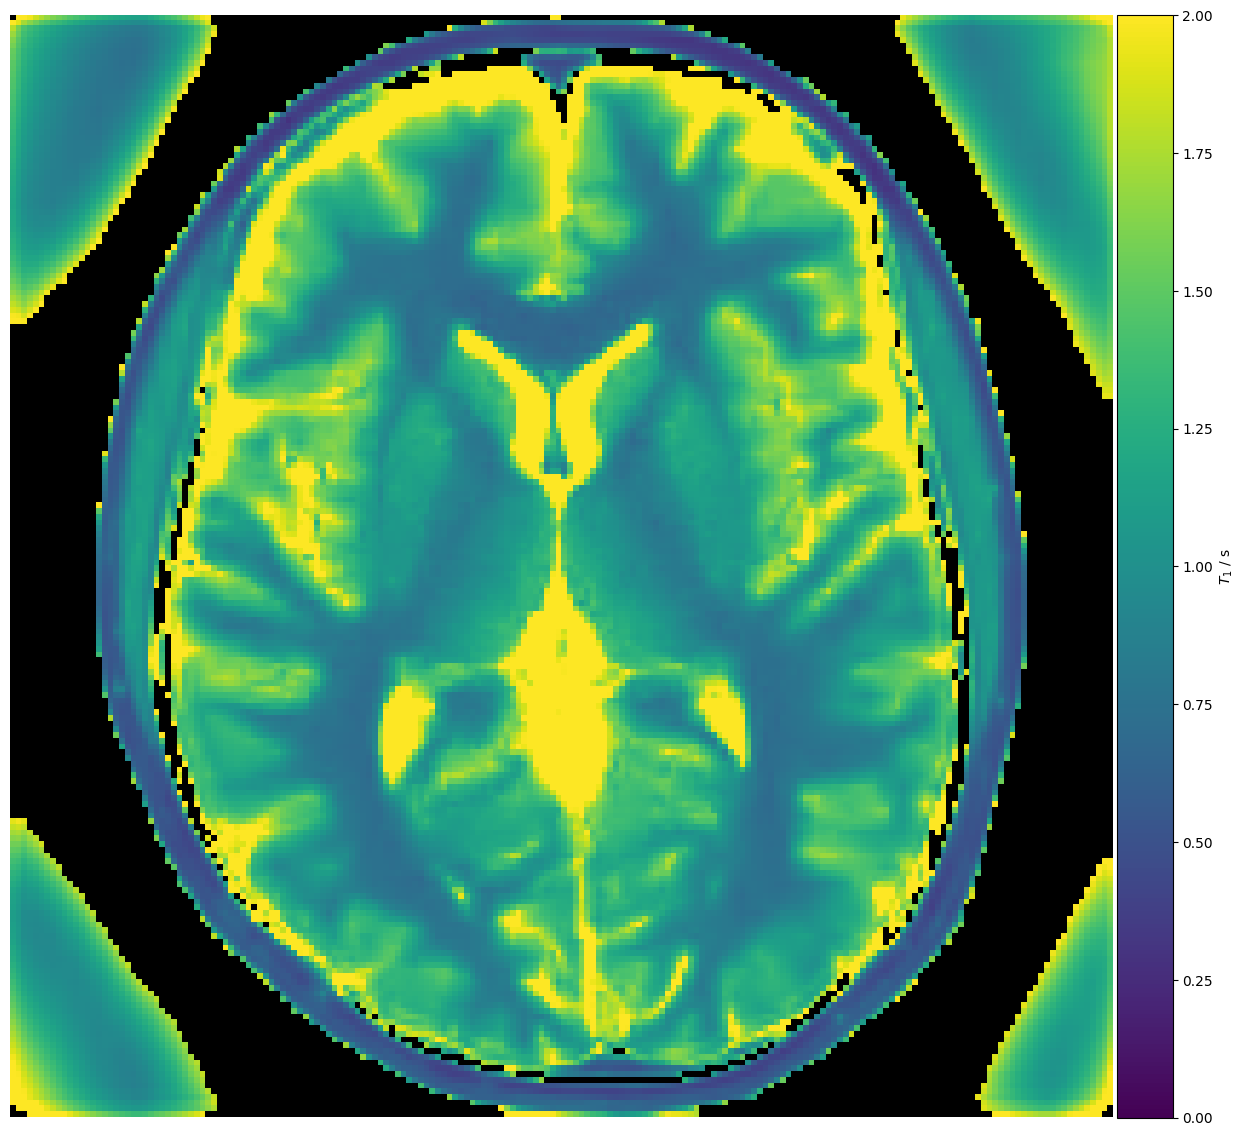

In [97]:
# python3 save_maps.py moba_T1map viridis 0 2.0 moba_T1map.png
plot_map("moba_T1map", "viridis", 0, 2, '$T_1$ / s')

### BART for Machine Learning - Reconstruction Networks

A specialized tutorial for neural networks in BART can be found in the [Workshop Material of the ISMRM 2021](https://github.com/mrirecon/bart-workshop/tree/master/ismrm2021).

#### Theory
We have implemented

> Variational Network<sup>1</sup>:
$$
x^{(i)} = x^{(i-1)}  - \lambda \nabla||Ax -b||^2 + Net(x^{(i-1)}, \Theta^{(i)} )
$$
> MoDL<sup>2</sup>:
$$
\begin{align}
z^{(i)} &= Net\left(x^{(i-1)}, \Theta \right)\\
x^{(i)} &= \mathrm{argmin}_x ||Ax -b||^2 + \lambda ||x - z^{(i)}||^2
\end{align}
$$

>Where
+ $A$ - MRI forward operator $\mathcal{PFC}$
    + $\mathcal{P}$ - Sampling pattern
    + $\mathcal{F}$ - Fourier transform
    + $\mathcal{C}$ - Coil sensitivity maps
+ $b$ - measured k-space data
+ $x^{(i)}$ - reconstruction after $i$ iterations
+ $x^{(0)}=A^Hb$ - initialization
+ $\Theta$ - Weights

>1: Hammernik, K. et al. (2018), [Learning a variational network for reconstruction of accelerated MRI data](https://doi.org/10.1002/mrm.26977). Magn. Reson. Med., 79: 3055-3071.

>2: Aggarwal, H. K. et al. (2019), [MoDL: Model-Based Deep Learning Architecture for Inverse Problems](https://doi.org/10.1109/TMI.2018.2865356). IEEE Trans. Med. Imag., 38(2): 394-405

To **train**, **evaluate** or **apply** unrolled networks, we provide the `bart reconet` command.

In [ ]:
! bart reconet -h

Usage: reconet [-t,--train] [-e,--eval] [-a,--apply] [-g,--gpu] [-l,--load <file>] [-b,--batch-size d] [-I,--iterations d] [-n,--normalize] [-N,--network ...] [--resnet-block ...] [--varnet-block ...] [--unet ...] [--data-consistency ...] [--initial-reco ...] [--shared-weights] [--no-shared-weights] [--shared-lambda] [--no-shared-lambda] [--rss-norm] [--trajectory <file>] [--pattern <file>] [--mask <file>] [--valid-data ...] [--train-loss ...] [--valid-loss ...] [-T,--train-algo ...] [--adam ...] [--iPALM ...] [--load-memory] [--lowmem] [--test] [--export-graph <string>] <kspace> <sensitivities> <weights> <ref/out> 

Trains or appplies a neural network for reconstruction.

-t,--train                   train reconet
-e,--eval                    evaluate reconet
-a,--apply                   apply reconet
-g,--gpu                     run on gpu
-l,--load <weights-init>     load weights for continuing training
-b,--batch-size d            size of mini batches
-I,--iterations d            n

In [ ]:
! bart reconet --network h

Usage of sub-option: -N,--network [modl],[varnet]

Sub-options: select neural network

modl      use MoDL Network (also sets train and data-consistency default values)
varnet    use Variational Network (also sets train and data-consistency default values)
h         help


#### Preparation of Knee-Data

Here, we use the data provided with the publication of the Variational Network, i.e. the coronal_pd_fs folder of the NYU-Dataset. The data has been converted to the .cfl-file format.   In the data folder, we find the fully-sampled kspace data of a knee and a sampling pattern. As the kspace is fully sampled, we can define a ground truth reference.

Before we apply the networks, we will create/estimate:
+ the downsampled kspace
+ coil sensitivity maps
+ a ground truth reference


# K-Space (fully sampled):
# Dimensions
640 368 1 15 1 1 1 1 1 1 1 1 1 1 1 1 

# Pattern:
# Dimensions
640 368 1 1 1 


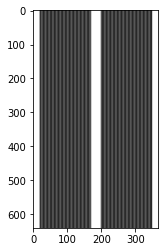

In [ ]:
! echo $'\n# K-Space (fully sampled):'
! head -n2 data/kspace_fs.hdr

! echo $'\n# Pattern:'
! head -n2 data/pattern_po_4.hdr

pattern = np.abs(cfl.readcfl("data/pattern_po_4"))
plt.imshow(pattern, cmap="gray")
plt.show()

#### Create Downsampled Kspace

We downsample the fully-sampled kspace by multiplying it with the sampling pattern:

In [ ]:
%%bash
bart fmac data/kspace_fs data/pattern_po_4 kspace

#### Estimate Coil Sensitivity Maps

We estimate the coil sensitivity maps using ESPIRiT. 

In [ ]:
%%bash
bart ecalib -r24 -m1 kspace coils_l
bart resize -c 0 320 coils_l coils

Done.


#### Reconstruction of the Reference

We construct the **ground truth reference** as the coil-combinded reconstruction of the fully-sampled kspace data. For comparison, we also compute a **l1-wavelet** regularized and the **zero-filled** reconstruction.

In [ ]:
%%bash

mkdir -p tmp

FFT_FLAG=$(bart bitmask 0 1)
COIL_FLAG=$(bart bitmask 3)

# Reference
bart fft -i -u $FFT_FLAG data/kspace_fs tmp/coil_image
bart fmac -C -s$COIL_FLAG tmp/coil_image coils_l tmp/image

# PICS l1
bart pics -S -l1 -r0.003 -p data/pattern_po_4 kspace coils_l tmp/pics_reco_l

# Zero-filled
bart fft -i -u $FFT_FLAG kspace tmp/coil_image_zf
bart fmac -C -s$COIL_FLAG tmp/coil_image_zf coils_l tmp/image_zf_l

#resize (frequency oversampling)
bart resize -c 0 320 tmp/image ref
bart resize -c 0 320 tmp/pics_reco_l pics_reco
bart resize -c 0 320 tmp/image_zf_l zero_filled

rm -r tmp

Size: 235520 Samples: 90880 Acc: 2.59
l1-wavelet regularization: 0.003000
FISTA
Total Time: 7.585275


We show the results:

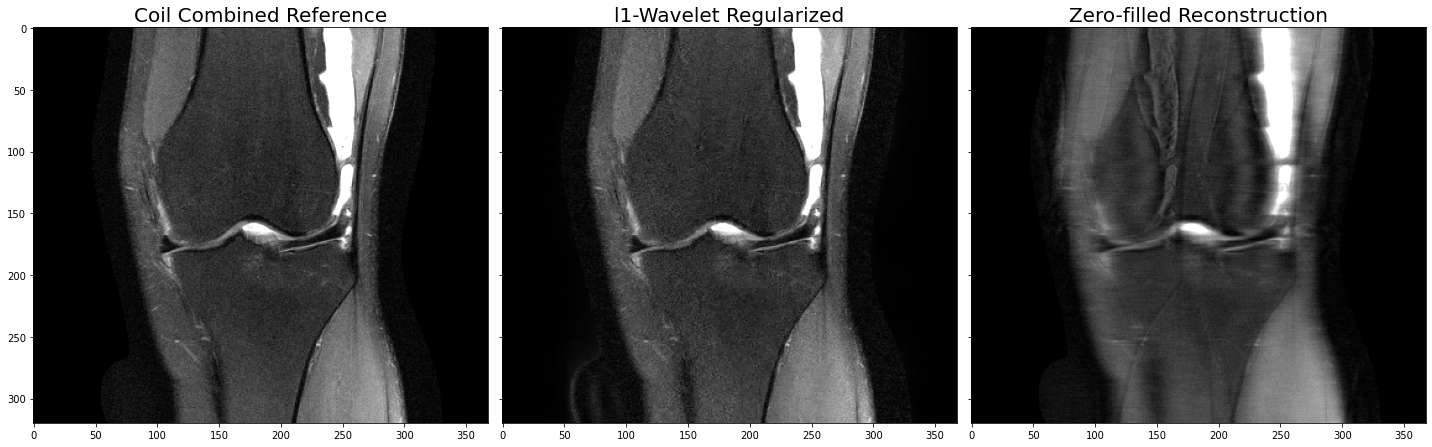

In [ ]:
ref = cfl.readcfl("ref")
pics_reco = cfl.readcfl("pics_reco")
zero_filled = cfl.readcfl("zero_filled")

vmax=0.5*np.max(np.abs(ref))

fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=3, sharex=True, sharey=True)

axes[0].imshow(np.abs(ref[::-1,::-1]), cmap="gray", vmax=vmax)
axes[0].set_title("Coil Combined Reference", fontsize=20)

axes[1].imshow(np.abs(pics_reco[::-1,::-1]), cmap="gray", vmax=vmax)
axes[1].set_title("l1-Wavelet Regularized", fontsize=20)

axes[2].imshow(np.abs(zero_filled[::-1,::-1]), cmap="gray", vmax=vmax)
axes[2].set_title("Zero-filled Reconstruction", fontsize=20)

plt.tight_layout()
plt.show()

#### Apply Variational Network

Having prepared the dataset, we can apply the Variational Network using the downloaded weights. The dataset is normalized by the maximum magnitude of the zero-filled reconstruction by using the `--normalize` option.  We use the pretrained weights provided in the weights directory. They have been trained on the first 15 knees from the coronal_pd_fs directory of the NYU-Dataset

In [ ]:
%%bash

# if BART is compiled with gpu support, we add the --gpu option
if $COLAB; then
    GPU=--gpu;
else
    GPU=''
fi

bart reconet \
    $GPU \
    --network=varnet \
    --normalize \
    --apply \
    --pattern=data/pattern_po_4 \
    kspace \
    coils \
    data/varnet \
    varnet

Apply RecoNet
NN
inputs: 6
adjoint        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coil           [320 368   1  15   1   1   1   1   1   1   1   1   1   1   1   1 ]
psf            [  1 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
lambda         [ 10 ]
conv           [ 24   1  11  11   1  10 ]
rbf            [ 24  31  10 ]
outputs: 1
INDEX 0        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]


We plot the results:

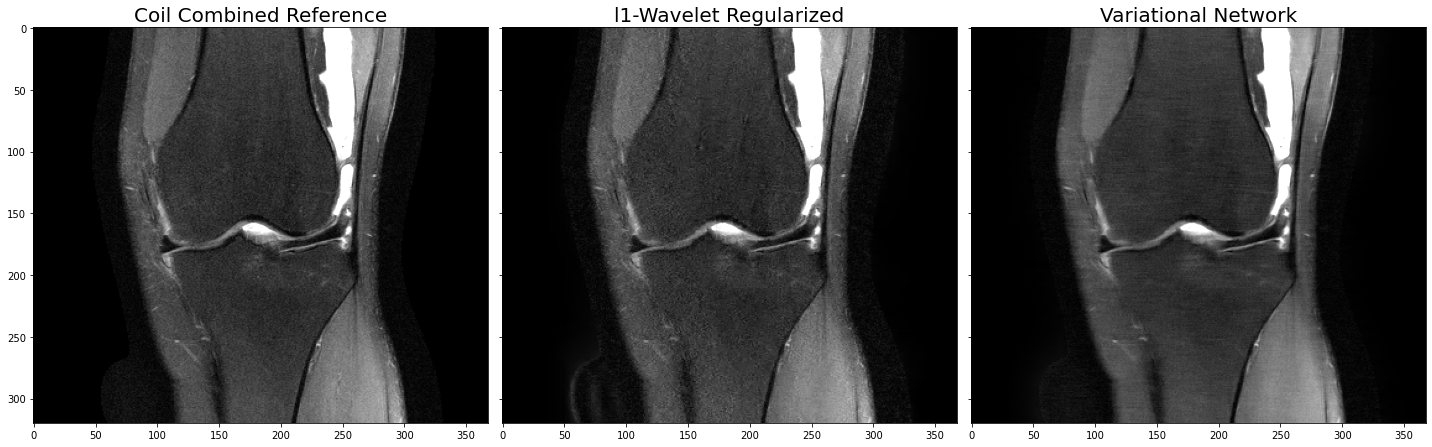

In [ ]:
ref = cfl.readcfl("ref")
pics_reco = cfl.readcfl("pics_reco")
varnet = cfl.readcfl("varnet")

vmax=0.5*np.max(np.abs(ref))

fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=3, sharex=True, sharey=True)

axes[0].imshow(np.abs(ref[::-1,::-1]), cmap="gray", vmax=vmax)
axes[0].set_title("Coil Combined Reference", fontsize=20)

axes[1].imshow(np.abs(pics_reco[::-1,::-1]), cmap="gray", vmax=vmax)
axes[1].set_title("l1-Wavelet Regularized", fontsize=20)

axes[2].imshow(np.abs(varnet[::-1,::-1]), cmap="gray", vmax=vmax)
axes[2].set_title("Variational Network", fontsize=20)

plt.tight_layout()
plt.show()

#### Apply MoDL

Similarly, MoDL can be applied using the provided weights. Here, we unroll 5 iterations.

In [ ]:
%%bash

# if BART is compiled with gpu support, we add the --gpu option
if $COLAB; then
    GPU=--gpu;
else
    GPU=''
fi

bart reconet \
    $GPU \
    --network=modl \
    --iterations=5 \
    --normalize \
    --apply \
    --pattern=data/pattern_po_4 \
    kspace \
    coils \
    data/modl \
    modl

Apply RecoNet
NN
inputs: 14
adjoint        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coil           [320 368   1  15   1   1   1   1   1   1   1   1   1   1   1   1 ]
psf            [  1 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
lambda         [  1 ]
conv_0         [ 32   1   3   3   1   1 ]
conv_i         [ 32  32   3   3   1   3   1 ]
conv_n         [  1  32   3   3   1   1 ]
bias_0         [ 32   1 ]
bias_i         [ 32   3   1 ]
bias_n         [  1   1 ]
gamma          [  1   1   1   1   1   5 ]
bn_0           [ 32   1   1   1   1   2   5 ]
bn_i           [ 32   1   1   1   1   2   3   5 ]
bn_n           [  1   1   1   1   1   2   5 ]
outputs: 4
INDEX 0        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
bn_0           [ 32   1   1   1   1   2   5 ]
bn_i           [ 32   1   1   1   1   2   3   5 ]
bn_n           [  1   1   1   1   1   2   5 ]


We plot the results:

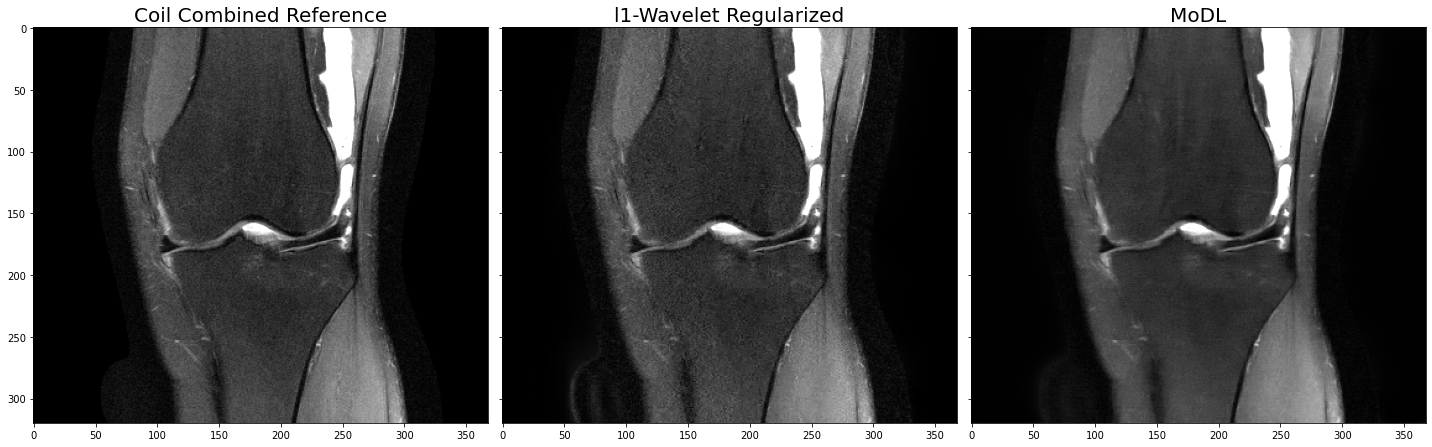

In [ ]:
ref = cfl.readcfl("ref")
pics_reco = cfl.readcfl("pics_reco")
modl = cfl.readcfl("modl")

vmax=0.5*np.max(np.abs(ref))

fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=3, sharex=True, sharey=True)

axes[0].imshow(np.abs(ref[::-1,::-1]), cmap="gray", vmax=vmax)
axes[0].set_title("Coil Combined Reference", fontsize=20)

axes[1].imshow(np.abs(pics_reco[::-1,::-1]), cmap="gray", vmax=vmax)
axes[1].set_title("l1-Wavelet Regularized", fontsize=20)

axes[2].imshow(np.abs(modl[::-1,::-1]), cmap="gray", vmax=vmax)
axes[2].set_title("MoDL", fontsize=20)

plt.tight_layout()
plt.show()

#### Evaluation of the Variational Network and MoDL

In [ ]:
%%bash

# if BART is compiled with gpu support, we add the --gpu option
if $COLAB; then
    GPU=--gpu;
else
    GPU=''
fi

bart reconet \
    $GPU \
    --network=varnet \
    --normalize \
    --eval \
    --pattern=data/pattern_po_4 \
    kspace \
    coils \
    data/varnet \
    ref 

Apply RecoNet
NN
inputs: 6
adjoint        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coil           [320 368   1  15   1   1   1   1   1   1   1   1   1   1   1   1 ]
psf            [  1 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
lambda         [ 10 ]
conv           [ 24   1  11  11   1  10 ]
rbf            [ 24  31  10 ]
outputs: 1
INDEX 0        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
mse mag: 3.902272e-12
mse: 7.057882e-12
mean psnr: 3.834483e+01
mean ssim: 9.027248e-01
mad: 2.575670e-06
mad mag: 1.365295e-06
nmse: 1.097741e-02
nmse mag: 6.069362e-03


In [ ]:
%%bash

# if BART is compiled with gpu support, we add the --gpu option
if $COLAB; then
    GPU=--gpu;
else
    GPU=''
fi

bart reconet \
    $GPU \
    --network=modl \
    --iterations=5 \
    --normalize \
    --eval \
    --pattern=data/pattern_po_4 \
    kspace \
    coils \
    data/modl \
    ref 

Apply RecoNet
NN
inputs: 14
adjoint        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
coil           [320 368   1  15   1   1   1   1   1   1   1   1   1   1   1   1 ]
psf            [  1 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
lambda         [  1 ]
conv_0         [ 32   1   3   3   1   1 ]
conv_i         [ 32  32   3   3   1   3   1 ]
conv_n         [  1  32   3   3   1   1 ]
bias_0         [ 32   1 ]
bias_i         [ 32   3   1 ]
bias_n         [  1   1 ]
gamma          [  1   1   1   1   1   5 ]
bn_0           [ 32   1   1   1   1   2   5 ]
bn_i           [ 32   1   1   1   1   2   3   5 ]
bn_n           [  1   1   1   1   1   2   5 ]
outputs: 4
INDEX 0        [320 368   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
bn_0           [ 32   1   1   1   1   2   5 ]
bn_i           [ 32   1   1   1   1   2   3   5 ]
bn_n           [  1   1   1   1   1   2   5 ]
mse mag: 4.344228e-12
mse: 7.402672e-12
mean psnr: 3.787887e+01
mean ssim